# Safety Prediction

    Location: Workshop
    Duration: 2019 - 2024 
    Purpose: 
    
    This project is designed to alert the superior to monitor more closely the specific technician due to his/her risk peercentage and past incident.
    

## Data Analysis
---


In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score, davies_bouldin_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Set the default Seaborn style for graphics
sb.set()


In [2]:
# Load the dataset
wsdp = pd.read_csv('workshop_incident_cleaned.csv')
wsdp['Date'] = pd.to_datetime(wsdp['Date'])

# Select numerical features for scaling
features = ['Age', 'Year of Tech', 'Experience', 'Reliability', 'Sleep', 'Temperature', 'Difficulty Level']

# Fit the StandardScaler on all features
scaler = StandardScaler()
wsdp_scaled = scaler.fit_transform(wsdp[features])
print(wsdp_scaled[:5])


[[ 4.7116097   2.38047614  3.79212135 -0.31448545  0.16552118 -1.12266699
  -1.33274983]
 [-0.23496216 -0.42008403 -1.00803226 -0.31448545  0.16552118 -1.12266699
   1.35063909]
 [-0.48229076 -0.42008403  0.19200614 -0.31448545  0.16552118 -1.12266699
   1.35063909]
 [-0.23496216 -0.42008403  0.19200614  3.17979734  0.16552118  0.31664967
  -0.43828686]
 [-0.23496216 -0.42008403  0.19200614 -0.31448545  0.16552118  0.31664967
  -1.33274983]]


C:\Users\tan_g\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


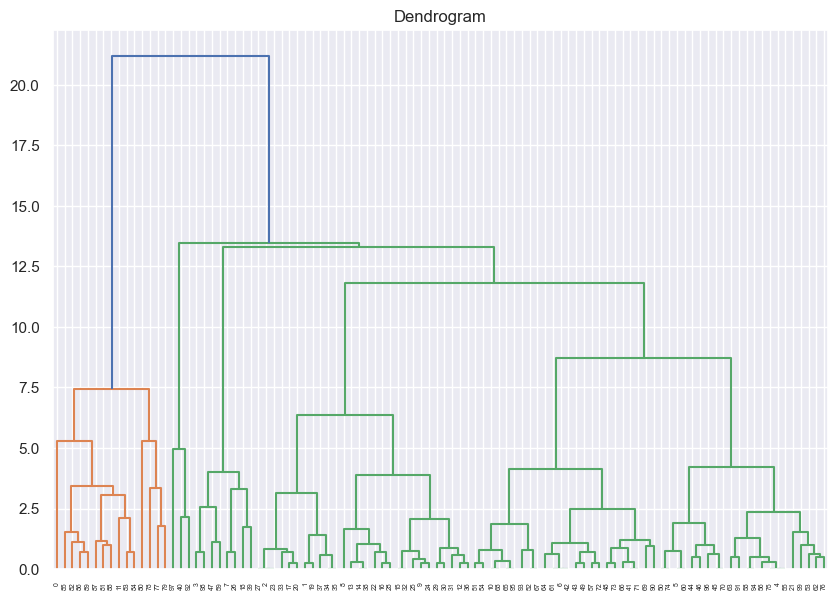

In [3]:
# Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  # Set the number of clusters
clusters = hc.fit_predict(wsdp_scaled)  # Fit the model and predict the clusters

# Add the cluster labels to the original DataFrame
wsdp['Cluster'] = clusters

# Visualize the Dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dend = sch.dendrogram(sch.linkage(wsdp_scaled, method='ward'))
plt.show()

In [5]:
# PCA Loading
pca = PCA(n_components=len(features))  # Number of components is equal to the number of features
pca.fit(wsdp_scaled)
loadings = pca.components_.T # Get loadings
loading_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=features) # Display loadings
print(loading_df)

# TUunderstand how much of the total variance in the data is captured by each principal component.
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)


                       PC1       PC2       PC3       PC4       PC5       PC6  \
Age               0.572967  0.002863 -0.062112  0.020520  0.178134 -0.429624   
Year of Tech      0.576206  0.094364 -0.054458  0.118637  0.010740 -0.344086   
Experience        0.536710 -0.205720  0.053260 -0.098176  0.182774  0.789735   
Reliability      -0.047041 -0.471477  0.040600  0.878800 -0.011027  0.017893   
Sleep             0.079005 -0.460651 -0.634825 -0.220941 -0.573362 -0.025820   
Temperature       0.177585  0.612767  0.045044  0.317666 -0.645289  0.223238   
Difficulty Level -0.107918  0.372550 -0.763976  0.232054  0.435296  0.150080   

                       PC7  
Age              -0.671650  
Year of Tech      0.723554  
Experience       -0.007632  
Reliability      -0.033414  
Sleep            -0.018160  
Temperature      -0.154293  
Difficulty Level  0.006715  
[0.36742149 0.17352467 0.14348107 0.13360429 0.11973829 0.0384469
 0.02378329]


In [8]:
# Calculate centroids for hierarchical clusters
def calculate_centroids(data, clusters, n_clusters):
    centroids = []
    for cluster in range(n_clusters):
        cluster_points = data[clusters == cluster]
        centroid = cluster_points.mean(axis=0)
        centroids.append(centroid)
    centroids = np.array(centroids)
    return centroids

centroids = calculate_centroids(wsdp_scaled, clusters, n_clusters=3)

# Calculate distances to centroids
distances = np.sqrt(((wsdp_scaled - centroids[clusters]) ** 2).sum(axis=1))
wsdp['Distance_to_Centroid'] = distances

In [10]:
# Calculate risk weights
num_components = 3  # Number of principal components to consider
#num_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
# Sum the absolute values of the loadings for the first few principal components
weights = np.sum(np.abs(loadings[:, :num_components]), axis=1)

# Normalize the weights to sum to 1
weights /= np.sum(weights)

# Create a dictionary of weights
risk_weights =  dict(zip(features, weights))
#print(wsdp_scaled)

# Add a weight for the distance to the centroid
risk_weights['Distance_to_Centroid'] = 0.25  # Example weight, adjust based on context

# Normalize the weights again to sum to 1
total_weight = sum(risk_weights.values())
risk_weights = {k: v / total_weight for k, v in risk_weights.items()}

# Calculate individual feature scores using the original values and the PCA weights
for feature in features + ['Distance_to_Centroid']:
    try:
        wsdp[f'{feature}_Score'] = wsdp[feature] * risk_weights[feature]
    except KeyError as e:
        print(f"KeyError for feature: {feature} - {e}")

threshold = np.mean(distances) + 3 * np.std(distances)  # Set the anomaly threshold
print(threshold)

# Add a column to indicate if the distance is more than the threshold
wsdp['Anomaly'] = np.where(distances > threshold, 'Yes', 'No')

# Display
risk_weights

    

4.074874453837322


{'Age': 0.08545630035105367,
 'Year of Tech': 0.09712196939624183,
 'Experience': 0.10658759597375922,
 'Reliability': 0.07489735695645727,
 'Sleep': 0.1573290647756247,
 'Temperature': 0.111906583747628,
 'Difficulty Level': 0.16670112879923532,
 'Distance_to_Centroid': 0.2}

In [12]:
# Calculate silhouette score
sil_score = silhouette_score(wsdp_scaled, clusters)
print(f'Silhouette Score: {sil_score:.3f}')

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(wsdp_scaled, clusters)
print(f'Davies-Bouldin Index: {db_index:.3f}')

# Calculate MSE
# For hierarchical clustering, calculate MSE differently as there's no direct centroid concept
#mse = mean_squared_error(wsdp_scaled, distances)
#print(f'Mean Squared Error: {mse:.3f}')

Silhouette Score: 0.490
Davies-Bouldin Index: 0.832


In [18]:
# Define the features to be used
likelihood_features = ['Age', 'Experience', 'Reliability', 'Sleep', 'Temperature', 'Year of Tech']
severity_features = ['Distance_to_Centroid', 'Difficulty Level']

# Aggregate the likelihood and severity scores
wsdp['Likelihood_Score'] = wsdp[[f'{feature}_Score' for feature in likelihood_features]].sum(axis=1)
wsdp['Severity_Score'] = wsdp[[f'{feature}_Score' for feature in severity_features]].sum(axis=1)

# Combine the likelihood and severity scores to calculate the total risk score
wsdp['Total_Risk_Score'] = wsdp['Likelihood_Score'] * wsdp['Severity_Score']
wsdp['Normalized_Risk_Score'] = (wsdp['Total_Risk_Score'] - wsdp['Total_Risk_Score'].min()) / (wsdp['Total_Risk_Score'].max() - wsdp['Total_Risk_Score'].min()) * 100

# Set options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Print the entire DataFrame
#wsdp

# Sort the DataFrame by Normalized_Risk_Score in descending order
sorted_wsdp = wsdp.sort_values(by='Anomaly', ascending=False)

# Display the DataFrame with the calculated risk scores in descending order of Normalized_Risk_Score
sorted_wsdp[['Member', 'Age', 'Year of Tech', 'Experience', 'Reliability', 'Sleep','Difficulty Level', 'Temperature','Anomaly','Cluster']]

,Member,Age,Year of Tech,Experience,Reliability,Sleep,Difficulty Level,Temperature,Anomaly,Cluster
0,Koh,41,2,5,1,7,1,27,Yes,1
63,Quinn Parker,20,1,2,1,7,1,31,No,0
73,Abigail Bell,23,1,1,1,7,4,30,No,0
72,Zachary Morgan,22,1,1,1,7,3,31,No,0
71,Yolanda Cook,21,1,1,1,7,4,31,No,0
70,Xavier Reed,20,1,1,1,7,1,31,No,0
69,Wanda Rogers,19,1,1,1,7,4,30,No,0
68,Vince Morris,20,1,2,1,7,3,31,No,0
67,Ulysses Stewart,20,1,2,1,7,4,31,No,0
66,Tina Collins,22,1,1,1,7,4,31,No,0


In [17]:
# Function to preprocess the new data point
def preprocess_data_point(new_data_point):
    new_data_point_array = np.array(new_data_point).reshape(1, -1)
    new_data_point_scaled = scaler.transform(new_data_point_array)
    return new_data_point_scaled

# Function to check if the new data point is an anomaly
def check_anomaly(new_data_point_scaled, cluster_centers, threshold):
    # Predict the cluster label for the new data point
    distances_to_centroids = np.sqrt(((cluster_centers - new_data_point_scaled) ** 2).sum(axis=1))
    new_data_point_cluster = np.argmin(distances_to_centroids)
    distance_to_centroid = distances_to_centroids[new_data_point_cluster]
    
    print(f"Distance to centroid: {distance_to_centroid}")
    print(f"Anomaly threshold: {threshold}")
    if distance_to_centroid > threshold:
        print("New data point is flagged as an anomaly.")
    else:
        print("New data point is NOT flagged as an anomaly.")


# Set the anomaly threshold
threshold = np.mean(distances) + 2 * np.std(distances)

# Example usage
while True:
    new_data_point = [float(input(f"Enter value for {feature}: ")) for feature in features]
    new_data_point_scaled = preprocess_data_point(new_data_point)
    check_anomaly(new_data_point_scaled, centroids, threshold)
    another_data_point = input("Do you want to input another data point? (yes/no): ")
    while another_data_point.lower() not in ['yes', 'no']:
        another_data_point = input("Please enter yes or no ONLY: ")
    if another_data_point == 'no':
        break



KeyboardInterrupt: Interrupted by user